In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as cls
import csv 
import copy
import vtk 
from plyfile import PlyData, PlyElement
import pymesh 

In [2]:
class VtkPointCloud:
    def __init__(self, zMin=-10.0, zMax=10.0, maxNumPoints=1e9):
        self.maxNumPoints = maxNumPoints
        self.vtkPolyData = vtk.vtkPolyData()
        self.clearPoints()
        self.mapper = vtk.vtkPolyDataMapper()
        self.mapper.SetInputData(self.vtkPolyData)
        self.mapper.SetColorModeToDefault()
#         self.mapper.SetScalarRange(zMin, zMax)
        self.mapper.SetScalarVisibility(1)
        self.vtkActor = vtk.vtkActor()
        self.vtkActor.SetMapper(self.mapper)
 
    def addPoint(self, point, color=None):
        pointId = 0
        if self.vtkPoints.GetNumberOfPoints() < self.maxNumPoints:
            pointId = self.vtkPoints.InsertNextPoint(point[:])
            self.vtkDepth.InsertNextValue(point[2])
            self.vtkCells.InsertNextCell(1)
            self.vtkCells.InsertCellPoint(pointId)
            
            if color is not None:
                self.Colors.InsertNextTuple3(int(color[0]), int(color[1]), int(color[2]))
            else:
                self.Colors.InsertNextTuple3(0, 255, 0)
                
                
            
        else:
            r = random.randint(0, self.maxNumPoints)
            self.vtkPoints.SetPoint(r, point[:])
        self.vtkCells.Modified()
        self.vtkPoints.Modified()
        self.vtkDepth.Modified()

        
        return pointId
    
        
    def addLine(self, pointId):
        input_line = vtk.vtkLine()
        input_line.GetPointIds().SetId(0,pointId[0])
        input_line.GetPointIds().SetId(1,pointId[1])
        self.vtkLines.InsertNextCell(input_line)
        self.vtkLines.Modified()
        
 
    def clearPoints(self):
        self.vtkPoints = vtk.vtkPoints()
        self.vtkCells = vtk.vtkCellArray()
        self.vtkLines = vtk.vtkCellArray()
        self.vtkDepth = vtk.vtkDoubleArray()
        self.vtkDepth.SetName('DepthArray')
        self.Colors = vtk.vtkUnsignedCharArray()
        self.Colors.SetNumberOfComponents(3)
        self.Colors.SetName("Colors")
        self.vtkPolyData.SetPoints(self.vtkPoints)
        self.vtkPolyData.SetVerts(self.vtkCells)
#         self.vtkPolyData.GetPointData().SetScalars(self.vtkDepth)
#         self.vtkPolyData.GetPointData().SetActiveScalars('DepthArray')
        self.vtkPolyData.GetPointData().SetScalars(self.Colors)
        self.vtkPolyData.GetPointData().SetActiveScalars("Colors")
        self.vtkPolyData.SetLines(self.vtkLines)
        
        
# def load_data(filename,pointCloud):

#     data = genfromtxt(filename,dtype=float,skiprows=2,usecols=[0,1,2])
     
#     for k in xrange(size(data,0)):
#         point = data[k] #20*(random.rand(3)-0.5)
#         pointCloud.addPoint(point)
         
#     return pointCloud

def load_data2(data, pointCloud):
     
    pointId = [0,0]  
    for k in range(len(data)):
        point = data[k] #20*(random.rand(3)-0.5)
        if k%2 == 0:
            pointId[0] = pointCloud.addPoint(point)
        else:
            pointId[1] = pointCloud.addPoint(point)
            pointCloud.addLine(pointId)
         
    return pointCloud

def load_more_points(data, pointCloud):
    for k in range(len(data)):
        point = data[k]
        if point.shape[0] == 3:
            pointCloud.addPoint(point)
        else:
            pointCloud.addPoint(point[0:3], point[3:6])
        
    return pointCloud

def load_lines(data, pointCloud):
     
    for k in range(len(data)):
#         pdb.set_trace()
        point = data[k] #20*(random.rand(3)-0.5)
#         print(point)
        pointCloud.addLine(point)
         
    return pointCloud
 


In [3]:
def close_window(iren):
    render_window = iren.GetRenderWindow()
    render_window.Finalize()
    iren.TerminateApp()

In [4]:
def getDepthpointFromRGB(u,v, K_rgb, K_depth):
    K_rgb_inv = np.linalg.inv(K_rgb)
    rgb_point = np.asarray([u,v,1,1], dtype=np.float64)
    homo_depth_point = np.dot(K_depth,np.dot(K_rgb_inv,rgb_point))
    u_depth = int(np.round(homo_depth_point[0]))
    v_depth = int(np.round(homo_depth_point[1]))
    return u_depth ,v_depth

In [5]:
def projectTo3D(u,v,z, K, T):
    K_inv = np.linalg.inv(K)
    rgb_point = np.asarray([z*u, z*v, z, 1], dtype=np.float64)
    depth_point = np.dot(K_inv, rgb_point)
    world_depth_point = np.dot(T, depth_point)
    return world_depth_point[0:3]

In [23]:
def read_ply(filename):
    """ read XYZ point cloud from filename PLY file """
    plydata = PlyData.read(filename)
    pc = plydata['vertex'].data
    if len(pc[0]) == 3:
        pc_array = np.array([[x, y, z] for x,y,z in pc])
    else:
        pc_array = np.array([[pc_elem[0],pc_elem[1],pc_elem[2],pc_elem[3],pc_elem[4],pc_elem[5],
                             pc_elem[6]] for pc_elem in pc])     
    return pc_array

In [7]:
# read depth image, color, K, T, semantic labels
depth_filename = '/home/sastrygrp2/data/Scannet/scans/downsampled_scans/rendered_depth/0.png'
rgb_filename  = '/home/sastrygrp2/data/Scannet/scans/downsampled_scans/color/0.jpg'
K_filename = '/home/sastrygrp2/data/Scannet/scans/downsampled_scans/intrinsic/intrinsic_depth.txt'
T_filename = '/home/sastrygrp2/data/Scannet/scans/downsampled_scans/pose/0.txt'
semantic_instance_labels_filename = '/home/sastrygrp2/data/Scannet/scans/downsampled_scans/instance/0.png'
semantic_labels_filename = '/home/sastrygrp2/data/Scannet/scans/downsampled_scans/label/0.png'

scannet_labels_filename = '/home/sastrygrp2/data/Scannet/tasks/scannet-labels.combined.tsv'

SCALE = 1000

In [8]:
depth_img = cv2.imread(depth_filename, cv2.IMREAD_UNCHANGED)/SCALE
rgb_img = cv2.imread(rgb_filename)
# sem_img = cv2.resize(sem_img,(640,480), interpolation=cv.INTER_NEAREST)
K = np.loadtxt(K_filename)
T = np.loadtxt(T_filename)
sem_inst_img = cv2.imread(semantic_instance_labels_filename, cv2.IMREAD_UNCHANGED)
sem_img = cv2.imread(semantic_labels_filename, cv2.IMREAD_UNCHANGED)
sem_img = cv2.resize(sem_img,(640,480), interpolation=cv2.INTER_NEAREST)

In [9]:
scannet_labels_dictionary = {}
scannet_labels_dictionary = csv.DictReader(open(scannet_labels_filename, mode='r'),delimiter="\t")
print(list(scannet_labels_dictionary)[0])

OrderedDict([('id', '1'), ('category', 'wall'), ('count', '7274'), ('nyuId', '21'), ('nyu40id', '1'), ('eigen13id', '12'), ('nyuClass', 'wall'), ('nyu40class', 'wall'), ('eigen13class', 'Wall'), ('ModelNet40', ''), ('ModelNet10', ''), ('ShapeNetCore55', ''), ('synsetoffset', ''), ('wnsynsetid', 'n04546855'), ('wnsynsetkey', 'wall.n.01')])


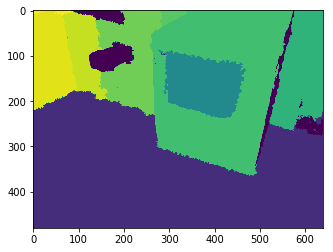

In [10]:
plt.imshow(sem_inst_img, norm=cls.Normalize())
plt.show()

In [11]:
idxs = np.where(sem_img != 62)
print(idxs)

(array([  0,   0,   0, ..., 479, 479, 479]), array([  0,   1,   2, ..., 637, 638, 639]))


In [12]:
tmp_img = copy.deepcopy(sem_inst_img)
tmp_img[idxs] = 0

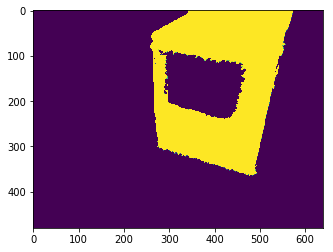

In [13]:
plt.imshow(tmp_img, norm=cls.Normalize())
plt.show()

In [14]:
oven_points = []
u_max = tmp_img.shape[1]
v_max = tmp_img.shape[0]

for u in range(u_max):
    for v in range(v_max):
        inst_label = tmp_img[v,u]
        if inst_label > 0:
            z = depth_img[v,u]
            world_3d_points = projectTo3D(u,v,z,K,T)
            oven_points.append(world_3d_points.tolist())

oven_points = np.asarray(oven_points)

In [32]:
centroid = np.mean(oven_points,axis=0)
print(centroid)
tip = centroid + np.asarray([0,0,1])*3

cad_oven = read_ply('/home/sastrygrp2/code/latent_3d_points/notebooks/oven.ply')
cad_mean = np.mean(cad_oven, axis=0)
cad_oven = cad_oven - np.asarray([cad_mean[0], cad_mean[1], cad_mean[2], 0,0,0,0])+ np.asarray([centroid[0], centroid[1], centroid[2],0,0,0,0])

[2.85831101 2.04935738 0.67269441]


In [33]:
pointCloud = VtkPointCloud()
pointCloud =load_more_points(oven_points, pointCloud)
pointCloud = load_more_points(cad_oven , pointCloud)
#"pointCloud2 =load_more_points(tsdf_points, pointCloud)\n",
#"# pointCloud =load_lines(all_lines, pointCloud)\n",

pointCloud = load_data2([centroid.tolist(), tip.tolist()], pointCloud)
# Rendered
renderer = vtk.vtkRenderer()
renderer.AddActor(pointCloud.vtkActor)

#renderer.SetBackground(.2, .3, .4)
renderer.SetBackground(0.0, 0.0, 0.0)
renderer.ResetCamera()

# Render Window
renderWindow = vtk.vtkRenderWindow()
renderWindow.AddRenderer(renderer)

# Interactor
renderWindowInteractor = vtk.vtkRenderWindowInteractor()
renderWindowInteractor.SetRenderWindow(renderWindow)

# Begin Interaction
renderWindow.Render()
renderWindow.SetWindowName("XYZ Data Viewer:")
renderWindowInteractor.Start()

close_window(renderWindowInteractor)
del renderWindow, renderWindowInteractor